In [54]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from scipy import stats

In [2]:
def get_graph_from_data_file(file_name='lesmis.txt', ncols=3):
    
    '''
    Defines a NetworkX graph based on data from file. 
    Plots a visual representation of the graph 
    '''
    
    file_path = 'data/' + file_name
    
    if ncols == 2:
        G = nx.read_edgelist("data/powergrid.txt", nodetype=int)
    else:
        G = nx.read_edgelist(file_path, nodetype=int, data=(('weight', float),))
        
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color='b', node_size=50, with_labels=False)
    
    G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    
    return G

In [63]:
def get_graph_data(G):
    print('Number of edges: {}. Number of nodes: {}.'.format(len(G), G.number_of_nodes()))
    vk = list(dict(G.degree()).values())
    vk = np.array(vk)
    print('Graph\'s mean degree: {}'.format(np.mean(vk)))

def degree_distribution(G):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    return kvalues,Pk

def momment_of_degree_distribution(G,m):
    k,Pk = degree_distribution(G)
    M = sum((k**m)*Pk)
    return M

def momment_of_degree_distribution2(G,m):
    'Moment of order m'
    M = 0
    N = len(G)
    for i in G.nodes:
        M = M + G.degree(i)**m
    M = M/N
    return M

def shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H

def normalized_shannon_entropy(G):
    k,Pk = degree_distribution(G)
    H = 0
    for p in Pk:
        if(p > 0):
            H = H - p*math.log(p, 2)
    return H/math.log(len(G),2)

# Transitivity and Clustering
def get_transitivity_data(G):
    CC = (nx.transitivity(G)) 

    avc = nx.average_clustering(G)
    vcc = []
    for i in G.nodes():
        vcc.append(nx.clustering(G, i))
    vcc= np.array(vcc)

    return [CC, avc]

def complexity_coefficient(G):
    return momment_of_degree_distribution(G, 2)/momment_of_degree_distribution(G,1)

# Distance
def graph_aspl(G):
    if nx.is_connected(G) == True:
        l = nx.average_shortest_path_length(G)
        return l
    else:
        return None
    
def get_spl_distribution(G):
    N = len(G)
    if nx.is_connected(G) == True:
        D = np.zeros(shape=(N,N)) # D is the matrix of distances
        vl = []
        d = nx.diameter(G)
        for i in np.arange(0,N):
            for j in np.arange(i+1, N):
                if(i != j):
                    aux = nx.shortest_path(G,i,j)
                    dij = len(aux)-1
                    D[i][j] = dij
                    D[j][i] = dij
                    vl.append(dij)
        x = range(0,d+1)
        plt.hist(vl, bins = x, density=True)
        plt.title("Distribution of the geodesic distances", fontsize=20)
        plt.ylabel("P(l)", fontsize=15)
        plt.xlabel("Shortest path length (l)", fontsize=15)
        #plt.grid(True)
        plt.savefig('av_short_path.eps')
        plt.show(True)
    else:
        None

def pearson_correlation(G):
    ki = []
    kj = []
    for i in range(0,len(G.nodes())):
        for j in range(0, len(G.nodes())):
            if(G.has_edge(i,j) == True):
                ki.append(G.degree(i))
                kj.append(G.degree(j))

    from scipy.stats import pearsonr
    # calculate Pearson's correlation
    corr, _ = pearsonr(ki, kj)
    return corr

def graph_knn(G):
    knn = []
    for i in G.nodes():
        aux =  nx.average_neighbor_degree(G, nodes = [i])
        knn.append(float(aux[i]))
    knn = np.array(knn)
    return knn
    

def get_graph_k_knn_corr(G):
    vk = dict(G.degree())
    vk = list(vk.values())
    knnk = list()
    ks = list()
    knn = graph_knn(G)
    for k in np.arange(np.min(vk), np.max(vk)+1):
        aux = vk == k
        if(len(knn[aux]) > 0):
            av_knn = np.mean(knn[aux]) #average clustering among all the nodes with degree k
            knnk.append(av_knn)
            ks.append(k)
    fig= plt.figure(figsize=(10,6))

    plt.plot(ks, knnk, '-o', color='gray',markersize=10, linewidth=0,
             markerfacecolor='lightgray',
             markeredgecolor='black',
             markeredgewidth=2)
    
    corr = np.corrcoef(ks, knnk)[0,1]
    s = stats.spearmanr(ks, knnk)
    spearman_corr = s[0]
    spearman_pval = s[1]
    
    plt.title("Corr. plot for k and knn (corr.: {:.2f}, spearman: {:.2f}, p-val: {:.3f})".format(corr,
                                                                                                spearman_corr,
                                                                                                spearman_pval), fontsize=20)
    plt.ylabel("knn(k)", fontsize=15)
    plt.xlabel("k", fontsize=15)
    

    
    #plt.loglog(ks,knnk,'bo',basex=10,basey=10)
    #plt.title("Average neighborhood connectivity vs degree")
    plt.ylabel("knn(k)", fontsize = 20)
    plt.xlabel("k", fontsize = 20)
    #plt.savefig('knnk.eps')

    # determine best fit line
    par = np.polyfit(ks, knnk, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(ks), max(ks)]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, '--', linewidth=3, color='black')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig('knn.eps') #save the figure into a file
    plt.show(True)


Number of nodes: 77
Number of edges: 254
Average shortest path length: 2.6411
Diameter: 5
Local efficiency: 0.6209
Assortativity: -0.1652
Pearson's correlation: -0.1652
Average degree of the neighborhood: 13.65


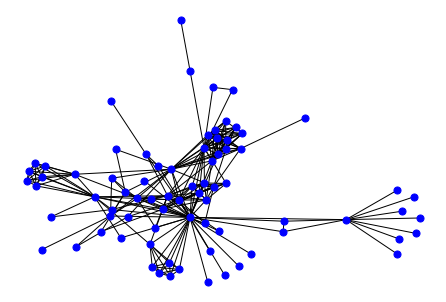

In [64]:
G = get_graph_from_data_file('lesmis.txt')

N = len(G)
M = G.number_of_edges()
D = graph_aspl(G)
print('Number of nodes:', N)
print('Number of edges:', M)
print('Average shortest path length: {:.4f}'.format(D))
print('Diameter: {}'.format(nx.diameter(G)))
print('Local efficiency: {:.4f}'.format(nx.local_efficiency(G)))
print("Assortativity: {:.4}".format(nx.degree_assortativity_coefficient(G)))
print("Pearson's correlation: {:.4}".format(pearson_correlation(G)))
print("Average degree of the neighborhood: {:.4}".format(np.mean(graph_knn(G))))

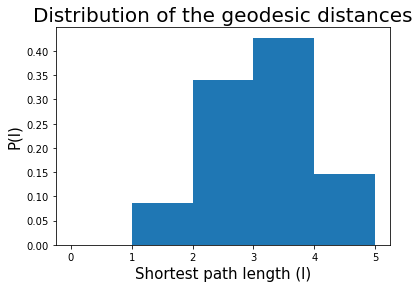

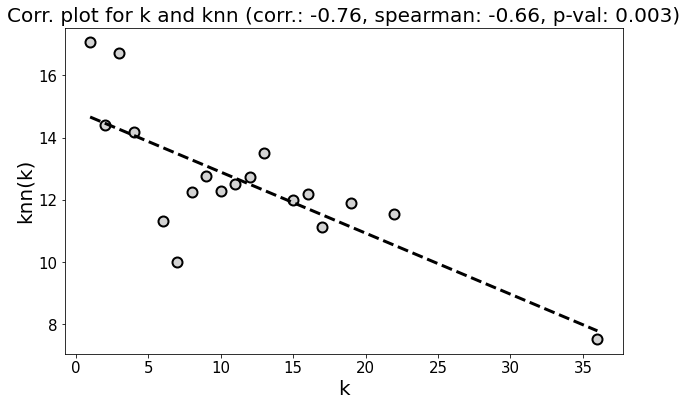

In [65]:
get_spl_distribution(G)
get_graph_k_knn_corr(G)